# <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2; text-align: center;">Progress Task 2 (Machine Learning Model Applications and Analysis)</div>

This notebook is a summary of the work done in this second task. We will describe briefly the preprocessing steps, the models used and their performance in the competition and the lessons we have learned.

<div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #0096FF; text-align: center;">FINAL POSITION</div>

We have tested several models for this task, a Neural Network, a Random Forest and a KNN model. More specifically the implementations used were:
* For the neural network:
  * A normal Keras model, with 3 hidden layers.
  * Using a combination of `scikit-learn`'s `RandomSearchCV` model, and a Keras model, to try to find the optimal hyperparameters for the network
  * `MLPClassifier`, a neural network implementation found in `scikit-learn`, instead of being taken from an external library like Keras.
* A Random Forest Model, developed using `scikit-learn`'s implementation. This model was the one with the best performance.
* KNN model <!-- TODO Not read this one, fill this in -->


## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Methodology</div>

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">**First attempt.** Random Forest 0.8520</div>

The first thing we did was inspecting the dataset and we realize that it had too many null values. Then, we decided to delete the rows that had these values since the dataset was so large that deleting a few rows wouldn't affect the training.  

**We were wrong.**

When we tried to do the same with the test dataset, we realized that we couldn’t simply ignore the null values and that we needed to handle them properly. For the treatment of nulls in categorical variables, we assigned a new category called 'missing,' and for numerical values, we used -1.
Later we removed some variables that seemed useless employment_industry or hhs_geo and encode both the training and test set using OrdinalEncoder. This is how we obtained the first dataset. After that, we needed to choose a model. 

Based on the results from the first task, we decided to try Random Forest with hyperparameter search, as it was the best among all the classifiers. 

**Result on competition: 0.8520** around 800th place which was around the middle of the leaderboard. Not bad for being the first attempt.


### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">**Trying to improve our ranking.** Gradient Boosting 0.8558</div>

To improve our ranking, we decided to follow two approaches: one would explore more Random Forest, and the other would investigate other models.

**1. Other models**

One teammate tried MLPClassifer as an inital approach to Neural Networks while other implemented a complete pipeline using Keras. The third one, tried KNN, but it didn't improve on the Random Forest results. In addition, KNN is influenced by class imbalance and outliers, and we haven't addressed these issues in the dataset.

After some time, we thought about trying other ensemble models. Searching into scikit-learn, we found out about Gradient Boosting models.

**Result on competition: 0.8487 for MLPClassifier**  
**Result on competition: 0.8464 for Neural Networks**, we had some issues with this model.  
**Result on competition: NOT tried for KNN**  
**Result on competition: 0.8558 for Gradient Boosting**  


**2. Random Forest**

We already had a satisfactory result with Random Forest, but we wondered if it could be improved. Since we decided not to fix any random states, we were able to run the tests multiple times and obtain very different results, which we saved in MLflow.

We tried several approaches:

- Running two separate Random Forest models, one for each target, and optimizing them independently instead of using a multi-output model.
- We also tried filtering the dataset for each target, using only the features relevant to that target. However, this approach performed much worse, as we lost relationships between the features.
- Finally, seeing that all of this was insufficient, we decided to use a "retraining" method on our initial approach. This improved performance, but only slightly.

We will no longer work with Random Forest as we have run out of ideas.

**Result on competition: 0.8538** with the best local Random Forest. 


### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">**What's next?: Use AI**</div>

We thought we had reached the limit with our approach, but to our surprise, the other teams were making significant improvements. We realized that we could also enhance our ranking by using all the tools available to us: Chat GPT and Claude.

We decided to try some prompt engineering by explaining to Chat GPT the context of our project, the problem we were tackling, and the models we had already tested. We asked for suggestions on other models we could use to improve our ranking score. After "debating" a bit with the chat, we came to the following conclusions:

- We could modify the dataset: This included addressing class imbalance or eliminating correlations.  
- Use basic models: Such as logistic regression or decision trees. However, we completely ruled this out since it wasn't aligned with our goals.  
- **Try more complex models:** Like Gradient Boosting Machines (e.g., XGBoost, LightGBM, CatBoost).  
- Optimize hyperparameters: By using libraries like Optuna or GridSearchCV.

Extracts of the conversations:

1. Is Optuna the same as Random Grid Search in sklearn?

🤖: Not exactly. Although Optuna and Grid/RandomizedSearchCV share the idea of searching for optimal hyperparameters, Optuna has several key differences that make it more flexible and efficient.

2. Explain briefly XGBoost, LightGBM, CatBoost

🤖: All of them are not native sklearn.   
**XGBoost**: Highly optimized for speed and performance but more complex to configure and tune.  
**LightGBM**: Faster than XGBoost in many cases, especially for large and high-dimensional datasets, handles categorical data natively (no encoding required), however can be sensitive to imbalanced data.   
**CatBoost**: Handles categorical features directly, often reduces overfitting automatically but has slower initial training compared to LightGBM.

**Therefore we decided to implement CatBoost with Optuna.**

**Result on competition: 0.8590**

------------

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Implementation</div>

❗**NOTE**  
The following section includes the implementation of the models. However, it’s important to note that this notebook was not used to develop the models, and we will not provide a detailed explanation of any of them here. The purpose of this notebook is to act as a summary and to compare the models. For more information, we recommend taking a look at the notebook dedicated to each specific model.

In [7]:
#import libraries
import pandas as pd
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, roc_curve
from sklearn.multioutput import MultiOutputClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Define a function to create a report of every model.

In [23]:
#Create a table to store the results of the models 
metrics =['Accuracy', 'F1-Macro', 'ROC AUC']
classification_results = pd.DataFrame(columns=metrics)

#Classification Summary Function
def report_classification(y_test, y_pred, model_name, y_pred_proba):
    a = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="macro")
    roc_auc = roc_auc_score(y_test, y_pred, average="macro")
    classification_results.loc[model_name] = [a, f1, roc_auc]
    
    print("============= METRICS FOR MODEL : ", model_name, " =================")
    print(f"Accuracy: {a}\nF1: {f1}\nRoc_Auc: {roc_auc}")
    print("==================== CONFUSION MATRIX ==========================")
    fig, ax = plt.subplots(1, 2, figsize=(12, 5))
    # Confusion matrix for h1n1 vaccine
    cm_h1n1 = confusion_matrix(y_test['h1n1_vaccine'], y_pred[:, 0], normalize='all')
    disp_h1n1 = ConfusionMatrixDisplay(confusion_matrix=cm_h1n1, display_labels=['No', 'Yes'])
    disp_h1n1.plot(ax=ax[0], colorbar=False)
    ax[0].set_title('Confusion Matrix for h1n1 Vaccine')

    # Confusion matrix for seasonal vaccine
    cm_seasonal = confusion_matrix(y_test['seasonal_vaccine'], y_pred[:, 1], normalize='all')
    disp_seasonal = ConfusionMatrixDisplay(confusion_matrix=cm_seasonal, display_labels=['No', 'Yes'])
    disp_seasonal.plot(ax=ax[1], colorbar=False)
    ax[1].set_title('Confusion Matrix for Seasonal Vaccine')

    plt.tight_layout()
    plt.show()
    print("==================== ROC AUC Curve ==========================")

    # Get predicted probabilities for positive classes
    y_scores = [p[:, 1] for p in y_pred_proba]

    plt.figure(figsize=(7, 5))
    for i, y_score in enumerate(y_scores):
        fpr, tpr, _ = roc_curve(y_test.iloc[:, i], y_score)
        auc = roc_auc_score(y_test.iloc[:, i], y_score)
        plt.plot(fpr, tpr, label=f'{y_test.columns[i]} (AUC = {auc:.4f})')

    plt.plot([0, 1], [0, 1], 'k--', label="Random")
    plt.title("ROC Curve")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend(loc="lower right")
    plt.grid()
    plt.show()

In [9]:
# import datasets
from mlflow.create_dataset import Dataset

data = Dataset()
X, y = data.with_correlation()
output = data.test

In [10]:
#train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state = 17)

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Random Forest</div>

In [ ]:
from sklearn.ensemble import RandomForestClassifier


model_to_train = MultiOutputClassifier(RandomForestClassifier(warm_start=True), n_jobs=-1)

In [ ]:
# initialize search hyperparameters
param_dist_random = {
                'estimator__n_estimators': randint(50, 200),
                'estimator__max_depth': [None, 10, 20, 30],
                'estimator__min_samples_split': randint(2, 11),
                'estimator__min_samples_leaf': randint(1, 5),
                'estimator__criterion': ['gini', 'entropy']
}
random_search = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist_random,
                                    n_iter=100, cv=5, n_jobs=-1, verbose=1,
                                    scoring='roc_auc')

In [ ]:
#train the model
# WARNING time: 11 min
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by random search:', random_search.best_params_)

In [ ]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
report_classification(y_test, y_pred, "Random Forest", y_pred_proba)

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">KNN</div>

In [11]:
from sklearn.neighbors import KNeighborsClassifier


model = MultiOutputClassifier(KNeighborsClassifier(n_neighbors=50, weights='uniform'), n_jobs=-1)

model.fit(X_train, y_train)    

y_pred_knn = model.predict(X_test)
y_pred_proba_knn = model.predict_proba(X_test)

============= METRICS FOR MODEL :  KNN  =================
Accuracy: 0.6473230999625609
F1: 0.5960440807696721
Roc_Auc: 0.7034349839557235
==================== CONFUSION MATRIX ==========================


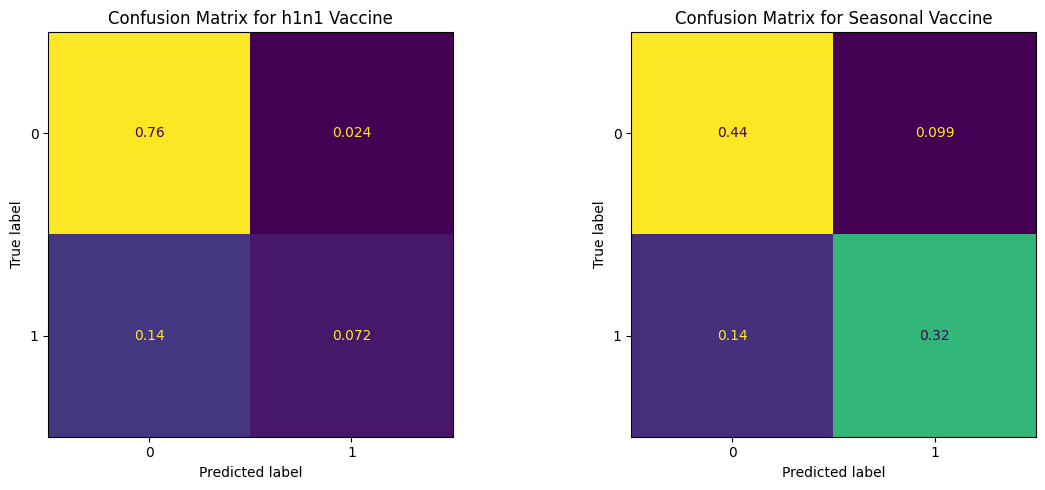

==================== ROC AUC Curve ==========================


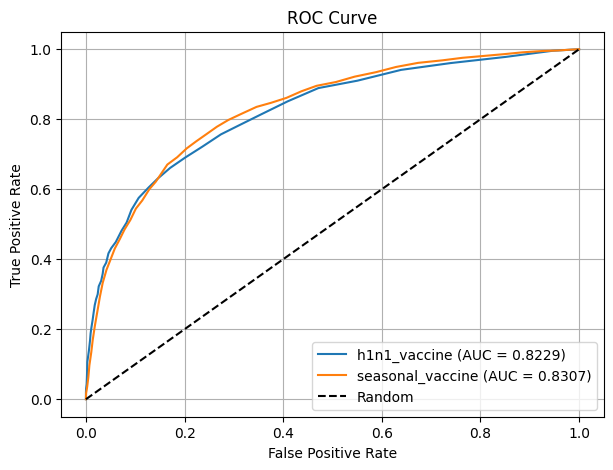

In [24]:
report_classification(y_test, y_pred_knn, "KNN", y_pred_proba_knn)
del y_pred_knn, y_pred_proba_knn

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">MLP Classifier</div>

In [25]:
from sklearn.neural_network import MLPClassifier

model_to_train = MultiOutputClassifier(MLPClassifier(early_stopping=True, solver='adam', 
                                                     learning_rate='constant', batch_size = 64, 
                                                     max_iter=2000), 
                                       n_jobs=-1)

In [ ]:
# initialize search hyperparameters
param_dist = {
    'estimator__hidden_layer_sizes': [
        (100,), (100, 50), (150,100,50), (100, 50, 25)
    ],
    'estimator__activation': ['tanh', 'relu', 'logistic'],
    'estimator__learning_rate_init': [0.0001, 0.001, 0.01],
    'estimator__alpha': [0.0001, 0.001, 0.01],
}

random_search = RandomizedSearchCV(estimator=model_to_train, 
                                   param_distributions=param_dist, n_iter=100, 
                                   cv=5, n_jobs=-1, verbose=0, scoring = 'roc_auc')

In [ ]:
# train model
# WARNING time: 25 minutes
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by grid search:', random_search.best_params_)

In [ ]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
report_classification(y_test, y_pred_knn, "MLP Classifier", y_pred_proba_knn)

### <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4a44c2;">Gradient Boosting</div>

In [ ]:
from sklearn.ensemble import HistGradientBoostingClassifier

# initialize model
model_to_train = MultiOutputClassifier(HistGradientBoostingClassifier(early_stopping=True), n_jobs=-1)

# hyperparameters optimization
param_dist_random = {
                'estimator__max_depth': [None, 10, 25, 50, 75, 100],
                'estimator__min_samples_leaf': randint(5, 50),
                'estimator__learning_rate': uniform(0.001, 0.2),
                'estimator__max_iter': randint(50, 500),
                'estimator__l2_regularization': uniform(0.001, 0.01),
                'estimator__max_bins': [50, 100, 200, 255],
    }
random_search = RandomizedSearchCV(estimator=model_to_train, param_distributions=param_dist_random,
                                    n_iter=100, cv=5, n_jobs=-1, verbose=1,
                                    scoring='roc_auc')

In [ ]:
# train model
# WARNING: time 6 min
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print('Best parameters found by random search:', random_search.best_params_)

In [ ]:
y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)
report_classification(y_test, y_pred_knn, "Gradient Boosting", y_pred_proba_knn)

## <div style="border: 3px solid #FFFFF; padding: 10px; border-radius: 5px; background-color: #4484c2;">Results</div>

In [ ]:
print('=========================== MODELS METRICS =======================================')
plt.figure(figsize=[16,8])
sns.heatmap(classification_results, annot=True, cmap='Blues', fmt='.4f', vmin=0, vmax=1)
plt.show()